# California Housing - Data Exploration

Taking a lot of inspiration from [this](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) Kaggle kernel by Pedro Marcelino, I will go through roughly the same steps using the classic California Housing price dataset in order to practice using Seaborn and doing data exploration in Python.

Secondly, this notebook will be used as a proof of concept of generating markdown version using `jupyter nbconvert --to markdown notebook.ipynb` in order to be posted to my [Jekyll blog](freddiek.github.io).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets.california_housing import fetch_california_housing
from scipy.stats import norm
from scipy import stats
%matplotlib inline

In [2]:
cal_housing = fetch_california_housing()
cal_housing.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [3]:
print(cal_housing.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [4]:
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = pd.DataFrame(cal_housing.target)
y.columns = ['HouseValue']

# Let's keep everything in one df for easy access
housing_data = pd.concat([X, y], axis=1)
housing_data.shape

(20640, 9)

In [5]:
housing_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### Feature definitions
As the StatLib [webpage](http://lib.stat.cmu.edu/) is down at the time of this writing, I don't know if there are any more information available about the dataset. The averages of income and housing price seem very low and similarly, I would have expected the average occupation to be a rate maybe around 50-75% depending on how it was defined.

However, for the purposes of this analysis it shouldn't not matter too much if they are measured in some unintuitive units, and anyhow since I'm doing this for learning rather than actually providing an accurate analysis, let's move on.

### Distribution of Outcome

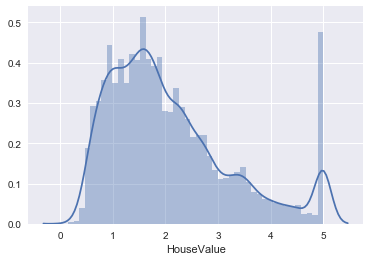

In [6]:
sns.distplot(housing_data['HouseValue']);

Ok, if this is not the definition of fishy then I don't know what is. What seems to have happened is that all average house values above a certain threshold have been adjusted down to the threshold. One possible reason for this might have been in order to avoid them having a too large impact on the average.

In [7]:
maxValue = housing_data.max().HouseValue
nrHouses = housing_data[housing_data.HouseValue == housing_data.max().HouseValue].shape[0]

print("Max house value:\t{} \nNr. of houses:\t\t{}".format(maxValue, nrHouses))

Max house value:	5.00001 
Nr. of houses:		965


In [8]:
print("Skewness: %f" % housing_data['HouseValue'].skew())
print("Kurtosis: %f" % housing_data['HouseValue'].kurt())

Skewness: 0.977763
Kurtosis: 0.327870


The distribution is somewhat skewed, but nothing remarkable. The low kurtosis number however illustrates clearly (if we didn't see that on the picture) that this is not a normal distribution.

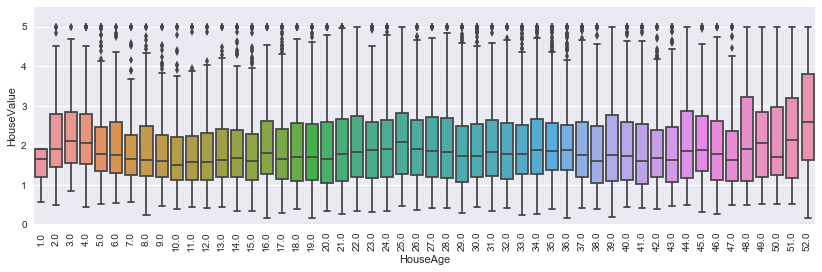

In [9]:
#box plot HouseValue
data = pd.concat([housing_data['HouseValue'], housing_data['HouseAge']], axis=1)
f, ax = plt.subplots(figsize=(14, 4))
fig = sns.boxplot(x=housing_data['HouseAge'], y="HouseValue", data=data)
fig.axis(ymin=0, ymax=maxValue+0.5);
plt.xticks(rotation=90);

Interestingly, the house prices for 52 year old houses are remarkably more expensive than any others. If we assume that really old houses would have on average higher prices than newer ones (as noone except for architects like modernistic architecture), this suggests that the highest average year of the houses might also have been adjusted down to a threshold.

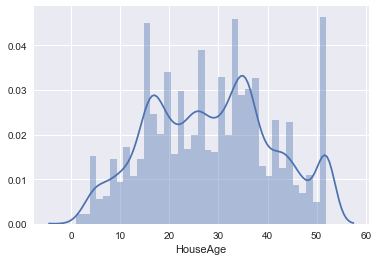

In [10]:
sns.distplot(housing_data['HouseAge']);

This seems to indicate a hard cutoff point at 52 years of age. Then again, as there are some other years with building booms, there might just have been one that year as well, and it's just happenstance that no older ages are in the dataset. Possible, but not likely.

### Feature Correlations

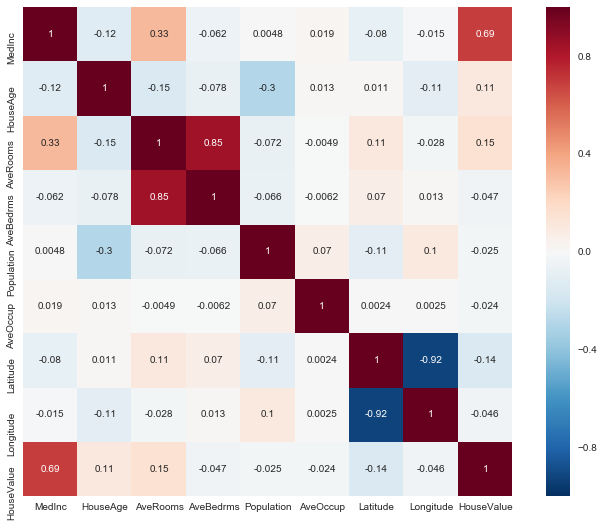

In [11]:
corrmat = housing_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True);

Looking at the pairwise correlation between the different features, it's clear that the housing value as strongly correlated with the average income of the area. No other feature is having a strong Pearson correlation with the price.

For some features, like the latitude and longitude, this makes a lot of sense since they by themselves don't contain useful information. Looking at them combined, it's likely though that we'd see a stronger predictive ability.

Some other are quite surprising though, like that the average number of rooms has such a weak correlation with price, and that the average income and average occupancy doesn't seem to correlate at all. I really must not be understanding the meaning of the AveOccup feature.

Let's look if the combination of Latitude and Longitude gives anything useful by plotting it in a 2D space.

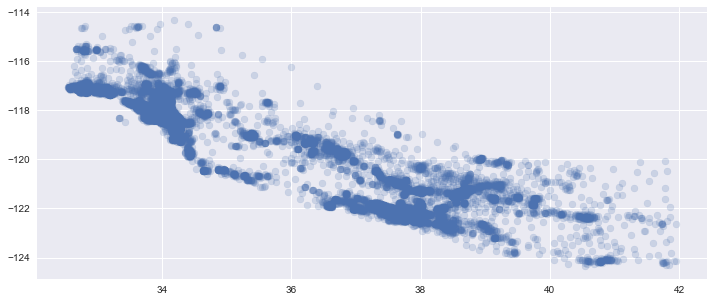

In [12]:
f, ax = plt.subplots(figsize=(12, 5))
plt.scatter(housing_data['Latitude'], housing_data['Longitude'], alpha=0.2)

It's clear that there are some areas that are more densely populated than others, and that the data is gathered from a rather specific geographic area.

Now let's add the house price (grouped into deciles) to see if there are any patterns.

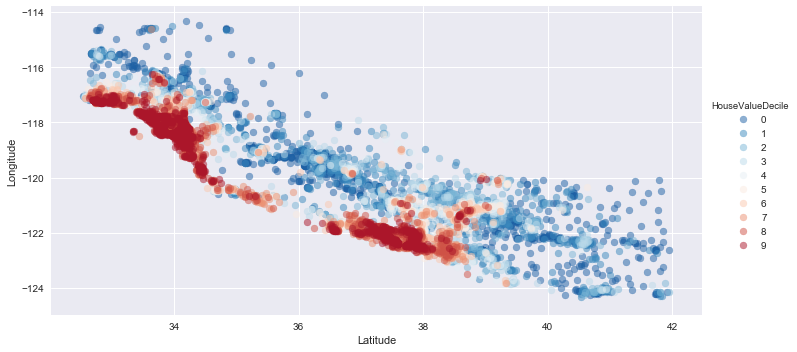

In [13]:
housing_data['HouseValueDecile'] = pd.qcut(housing_data['HouseValue'], 10, labels=np.arange(0, 10, 1))
fg = sns.FacetGrid(data=housing_data, hue='HouseValueDecile', palette='RdBu_r', size=5, aspect=2)
fg.map(plt.scatter, 'Latitude', 'Longitude', alpha=0.5).add_legend()

There are clear patterns when comparing the more expensive areas to less expensive. (This would also be fun to put as an overlay on Google Maps. Alas, next time maybe).

In [14]:
# Let's remove the deciles from the dataset again as they don't contain any extra data
del housing_data['HouseValueDecile']

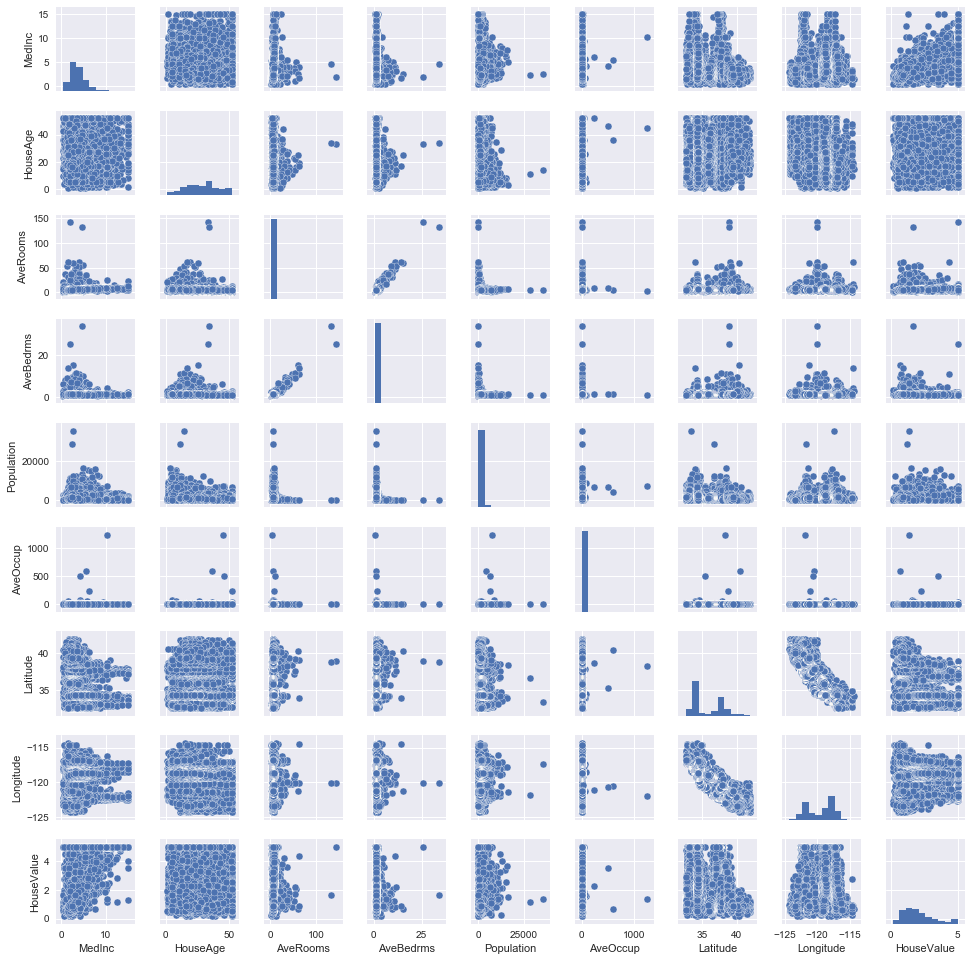

In [15]:
sns.pairplot(housing_data, size = 1.5)
plt.show();

Pair plots are generally very informative. Here, it's clear that there are some outlier data points in several features that might have get too much leverage on any linear models we build, and will create overfitted models for any alghorithm if we believe that they are not representative of the actual distribution.

Lets also look closer at the HouseValue to MedInc as that is the strongest correlation.

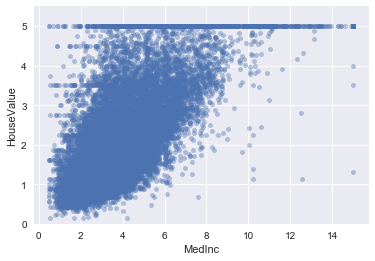

In [16]:
data = pd.concat([housing_data['HouseValue'], housing_data['MedInc']], axis=1)
data.plot.scatter(x='MedInc', y='HouseValue', alpha=0.4, ylim=(0,maxValue+0.5));

Some outliers, but nothing that should impact a model badly, except of course for the issue with the cutoff point.

### Applying Log Transformation on House Value

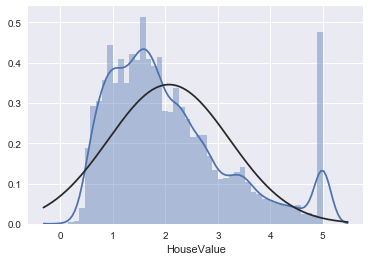

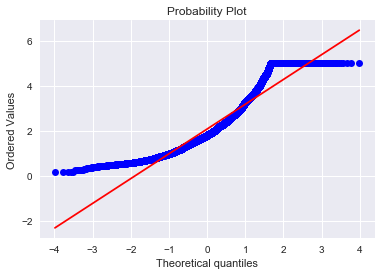

In [17]:
sns.distplot(housing_data['HouseValue'], fit=norm);
fig = plt.figure()
res = stats.probplot(housing_data['HouseValue'], plot=plt)

Investigating the distribution of the prices, doesn't follow a normal distribution except for around the mean. In order to at least improve this somewhat, we can transform the feature to it's log version.

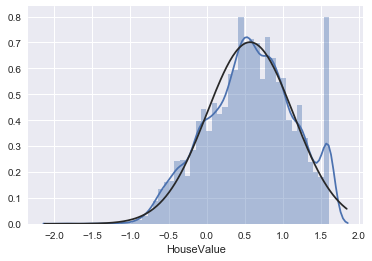

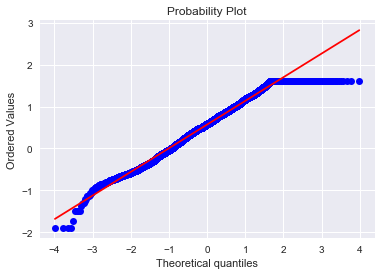

In [18]:
housing_data['HouseValue'] = np.log(housing_data['HouseValue'])
sns.distplot(housing_data['HouseValue'], fit=norm);
fig = plt.figure()
res = stats.probplot(housing_data['HouseValue'], plot=plt)

Now that's a fine line.

### Takeaways
* **Suitable alghorithms** - Linear models will not work well in all cases as the house value and other features too are discontinuous in their behaviour, which suggests that alghorithms like a decision trees might yield better results.
* **Feature importance** - The average income is the single strongest correlated feature, with house age and number of rooms also having weak correlation. The combination of latitude and longitude does have strong predictive power in some cases too, which further speaks for a non-linear model.
* **Note to self** - I need to read up on in which scenarios and for which alghorithms log transformations of non-normal distributed features makes sense.